In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt

In [3]:
DATA = "/content/drive/MyDrive/Capstone_Datasets"

In [4]:
def load_fred(csv_path, value_name):
    df = pd.read_csv(csv_path)
    df = df.rename(columns={"observation_date": "date", df.columns[1]: value_name})
    df["date"] = pd.to_datetime(df["date"])
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
    return df[["month", value_name]]


    # now read only from header row
    df = pd.read_csv(csv_path, skiprows=header_idx)
    date_col = 'DATE' if 'DATE' in df.columns else 'observation_date'
    val_col  = [c for c in df.columns if c != date_col][0]
    df = df.rename(columns={date_col:'date', val_col:value_name})
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp('M')
    return df[['month', value_name]]

def load_and_monthly_avg(csv_path, value_name):
    with open(csv_path, 'r') as f:
        lines = f.readlines()
    header_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith("DATE"):
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("No DATE header found in file!")

    df = pd.read_csv(csv_path, skiprows=header_idx)
    date_col = 'DATE' if 'DATE' in df.columns else 'observation_date'
    val_col  = [c for c in df.columns if c != date_col][0]
    df = df.rename(columns={date_col:'date', val_col:value_name})
    df['date'] = pd.to_datetime(df['date'])
    df = (df.set_index('date').resample('M').mean().reset_index())
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp('M')
    return df[['month', value_name]]

In [5]:
hires = load_fred(f"{DATA}/JTSHIL.csv", "hires_thousands")

print("Total Rows:", len(hires))
hires.head(10)



Total Rows: 296


,month,hires_thousands
0,2000-12-31,5426
1,2001-01-31,5722
2,2001-02-28,5303
3,2001-03-31,5528
4,2001-04-30,5204
5,2001-05-31,5410
6,2001-06-30,5109
7,2001-07-31,5244
8,2001-08-31,5223
9,2001-09-30,4954


In [6]:
openings = load_fred(f"{DATA}/JTSJOL.csv", "openings_thousands")
quits    = load_fred(f"{DATA}/JTUQUR.csv", "quits_rate")
layoffs  = load_fred(f"{DATA}/JTSLDR.csv", "layoffs_rate")
unrate   = load_fred(f"{DATA}/UNRATE.csv", "unrate_pct")
indpro   = load_fred(f"{DATA}/INDPRO.csv", "indpro_index")
recess   = load_fred(f"{DATA}/USRECP.csv", "recession_dummy")

print("Rows per dataset:")
print("Openings:", len(openings))
print("Quits:", len(quits))
print("Layoffs:", len(layoffs))
print("Unrate:", len(unrate))
print("Industrial Production:", len(indpro))
print("Recession:", len(recess))

print("\nSample Job Openings:")
openings.head(10)


Rows per dataset:
Openings: 296
Quits: 296
Layoffs: 296
Unrate: 932
Industrial Production: 1280
Recession: 2049

Sample Job Openings:


,month,openings_thousands
0,2000-12-31,5088
1,2001-01-31,5234
2,2001-02-28,5097
3,2001-03-31,4762
4,2001-04-30,4615
5,2001-05-31,4425
6,2001-06-30,4361
7,2001-07-31,4447
8,2001-08-31,4024
9,2001-09-30,4071


In [7]:
def load_and_monthly_avg(csv_path, value_name):
    df = pd.read_csv(csv_path)
    df = df.rename(columns={"observation_date": "date", df.columns[1]: value_name})
    df["date"] = pd.to_datetime(df["date"])
    # resample to monthly mean
    df = df.set_index("date").resample("M").mean().reset_index()
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
    return df[["month", value_name]]

# Weekly / daily → monthly
claims   = load_and_monthly_avg(f"{DATA}/ICSA.csv", "claims_monthly")
postings = load_and_monthly_avg(f"{DATA}/IHLIDXUS.csv", "postings_index_m")




/tmp/ipython-input-918904921.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index("date").resample("M").mean().reset_index()
/tmp/ipython-input-918904921.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index("date").resample("M").mean().reset_index()


In [8]:
print("Claims (monthly avg):", len(claims))
print("Postings (monthly avg):", len(postings))

print("\nSample Claims:")
claims.head()

Claims (monthly avg): 705
Postings (monthly avg): 68

Sample Claims:


,month,claims_monthly
0,1967-01-31,209000.0
1,1967-02-28,229000.0
2,1967-03-31,260750.0
3,1967-04-30,263000.0
4,1967-05-31,235750.0


In [9]:
from functools import reduce

frames = [
    hires, openings, quits, layoffs, unrate,
    claims, postings, indpro, recess
]

df = reduce(lambda l, r: pd.merge(l, r, on="month", how="left"), frames)

# keep only rows with target available
df = df.dropna(subset=["hires_thousands"]).copy()
df["date"] = df["month"]


In [10]:
print("Final merged shape:", df.shape)
df.head(10)

Final merged shape: (296, 11)


,month,hires_thousands,openings_thousands,quits_rate,layoffs_rate,unrate_pct,claims_monthly,postings_index_m,indpro_index,recession_dummy,date
0,2000-12-31,5426,5088,1.7,1.5,3.9,346000.0,NaN,92.3457,0,2000-12-31
1,2001-01-31,5722,5234,2.6,1.7,4.2,340000.0,NaN,91.8908,0,2001-01-31
2,2001-02-28,5303,5097,1.9,1.4,4.2,371250.0,NaN,91.2851,0,2001-02-28
3,2001-03-31,5528,4762,2.0,1.6,4.3,387200.0,NaN,91.0585,1,2001-03-31
4,2001-04-30,5204,4615,2.5,1.4,4.4,396750.0,NaN,90.7384,1,2001-04-30
5,2001-05-31,5410,4425,2.2,1.5,4.3,394500.0,NaN,90.2607,1,2001-05-31
6,2001-06-30,5109,4361,2.2,1.5,4.5,397200.0,NaN,89.7811,1,2001-06-30
7,2001-07-31,5244,4447,2.6,1.5,4.6,398000.0,NaN,89.2352,1,2001-07-31
8,2001-08-31,5223,4024,2.8,1.5,4.9,398000.0,NaN,89.1570,1,2001-08-31
9,2001-09-30,4954,4071,2.2,1.6,5.0,435000.0,NaN,88.6749,1,2001-09-30


In [11]:
# Month number & month name
df["mo"] = df["month"].dt.month
df["month_name"] = df["mo"].apply(lambda m: calendar.month_abbr[m].upper())

# One-hot encode month names (JAN, FEB, …)
month_dummies = pd.get_dummies(df["month_name"], prefix="mo", dtype=int)
df = pd.concat([df, month_dummies], axis=1)

# Lags and rolling stats
df["hires_lag1"]  = df["hires_thousands"].shift(1)
df["hires_lag12"] = df["hires_thousands"].shift(12)
df["hires_ma3"]   = df["hires_thousands"].rolling(3).mean()

# YoY growth for Industrial Production
df["indpro_yoy"] = df["indpro_index"].pct_change(12) * 100


In [12]:
print("Final shape after feature engineering:", df.shape)

Final shape after feature engineering: (296, 29)


In [13]:
df.head(12)

,month,hires_thousands,openings_thousands,quits_rate,layoffs_rate,unrate_pct,claims_monthly,postings_index_m,indpro_index,recession_dummy,...,mo_JUN,mo_MAR,mo_MAY,mo_NOV,mo_OCT,mo_SEP,hires_lag1,hires_lag12,hires_ma3,indpro_yoy
0,2000-12-31,5426,5088,1.7,1.5,3.9,346000.0,NaN,92.3457,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,2001-01-31,5722,5234,2.6,1.7,4.2,340000.0,NaN,91.8908,0,...,0,0,0,0,0,0,5426.0,NaN,NaN,NaN
2,2001-02-28,5303,5097,1.9,1.4,4.2,371250.0,NaN,91.2851,0,...,0,0,0,0,0,0,5722.0,NaN,5483.666667,NaN
3,2001-03-31,5528,4762,2.0,1.6,4.3,387200.0,NaN,91.0585,1,...,0,1,0,0,0,0,5303.0,NaN,5517.666667,NaN
4,2001-04-30,5204,4615,2.5,1.4,4.4,396750.0,NaN,90.7384,1,...,0,0,0,0,0,0,5528.0,NaN,5345.000000,NaN
5,2001-05-31,5410,4425,2.2,1.5,4.3,394500.0,NaN,90.2607,1,...,0,0,1,0,0,0,5204.0,NaN,5380.666667,NaN
6,2001-06-30,5109,4361,2.2,1.5,4.5,397200.0,NaN,89.7811,1,...,1,0,0,0,0,0,5410.0,NaN,5241.000000,NaN
7,2001-07-31,5244,4447,2.6,1.5,4.6,398000.0,NaN,89.2352,1,...,0,0,0,0,0,0,5109.0,NaN,5254.333333,NaN
8,2001-08-31,5223,4024,2.8,1.5,4.9,398000.0,NaN,89.1570,1,...,0,0,0,0,0,0,5244.0,NaN,5192.000000,NaN
9,2001-09-30,4954,4071,2.2,1.6,5.0,435000.0,NaN,88.6749,1,...,0,0,0,0,0,1,5223.0,NaN,5140.333333,NaN


In [14]:
df.columns

Index(['month', 'hires_thousands', 'openings_thousands', 'quits_rate',
       'layoffs_rate', 'unrate_pct', 'claims_monthly', 'postings_index_m',
       'indpro_index', 'recession_dummy', 'date', 'mo', 'month_name', 'mo_APR',
       'mo_AUG', 'mo_DEC', 'mo_FEB', 'mo_JAN', 'mo_JUL', 'mo_JUN', 'mo_MAR',
       'mo_MAY', 'mo_NOV', 'mo_OCT', 'mo_SEP', 'hires_lag1', 'hires_lag12',
       'hires_ma3', 'indpro_yoy'],
      dtype='object')

In [15]:
# Drop any existing month-dummy columns
dup_mo_cols = [c for c in df.columns if c.startswith('mo_')]
df = df.drop(columns=dup_mo_cols, errors='ignore')

# Recreate a single, clean month_name and month dummies (JAN..DEC)
import calendar
df['mo'] = df['month'].dt.month
df['month_name'] = df['mo'].apply(lambda m: calendar.month_abbr[m].upper())

month_order = [m.upper() for m in calendar.month_abbr if m]  # ['JAN','FEB',...,'DEC']
month_dummies = (
    df['month_name']
      .astype(pd.CategoricalDtype(categories=month_order, ordered=True))
      .pipe(pd.get_dummies, prefix='mo', dtype=int)
)
df = pd.concat([df, month_dummies], axis=1)

In [16]:
present_cols = [
    'month',                 # timeline key
    'hires_thousands',       # TARGET
    'openings_thousands',    # demand
    'quits_rate',            # worker confidence
    'layoffs_rate',          # downturn signal
    'unrate_pct',            # slack
    'claims_monthly',        # leading (monthly avg)
    'postings_index_m',      # demand (2020+)
    'indpro_index',          # macro activity
    'indpro_yoy',            # macro trend (YoY)
    'recession_dummy',       # regime
    'month_name',            # JAN..DEC
    'hires_lag1', 'hires_lag12', 'hires_ma3'  # memory
] + list(month_dummies.columns)              # exactly 12 mo_* columns

df_view = df[present_cols].copy()
print("shape:", df_view.shape)
df_view.head(10)

shape: (296, 27)


,month,hires_thousands,openings_thousands,quits_rate,layoffs_rate,unrate_pct,claims_monthly,postings_index_m,indpro_index,indpro_yoy,...,mo_MAR,mo_APR,mo_MAY,mo_JUN,mo_JUL,mo_AUG,mo_SEP,mo_OCT,mo_NOV,mo_DEC
0,2000-12-31,5426,5088,1.7,1.5,3.9,346000.0,NaN,92.3457,NaN,...,0,0,0,0,0,0,0,0,0,1
1,2001-01-31,5722,5234,2.6,1.7,4.2,340000.0,NaN,91.8908,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2001-02-28,5303,5097,1.9,1.4,4.2,371250.0,NaN,91.2851,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2001-03-31,5528,4762,2.0,1.6,4.3,387200.0,NaN,91.0585,NaN,...,1,0,0,0,0,0,0,0,0,0
4,2001-04-30,5204,4615,2.5,1.4,4.4,396750.0,NaN,90.7384,NaN,...,0,1,0,0,0,0,0,0,0,0
5,2001-05-31,5410,4425,2.2,1.5,4.3,394500.0,NaN,90.2607,NaN,...,0,0,1,0,0,0,0,0,0,0
6,2001-06-30,5109,4361,2.2,1.5,4.5,397200.0,NaN,89.7811,NaN,...,0,0,0,1,0,0,0,0,0,0
7,2001-07-31,5244,4447,2.6,1.5,4.6,398000.0,NaN,89.2352,NaN,...,0,0,0,0,1,0,0,0,0,0
8,2001-08-31,5223,4024,2.8,1.5,4.9,398000.0,NaN,89.1570,NaN,...,0,0,0,0,0,1,0,0,0,0
9,2001-09-30,4954,4071,2.2,1.6,5.0,435000.0,NaN,88.6749,NaN,...,0,0,0,0,0,0,1,0,0,0


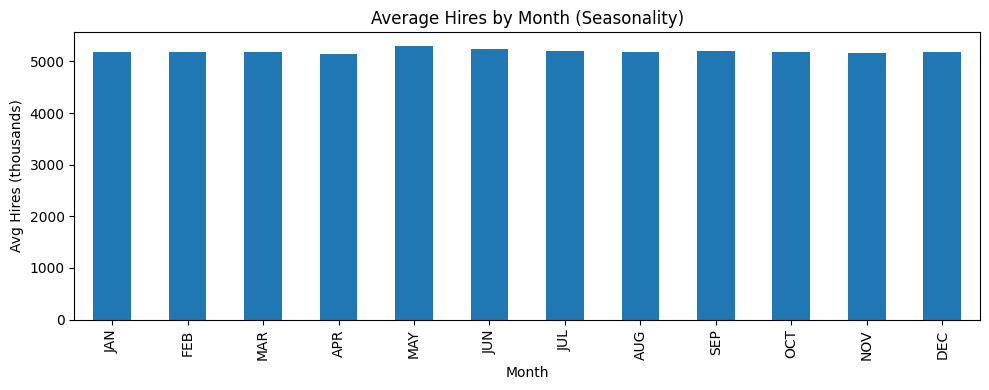

,hires_thousands
month_name,
JAN,5176.640000
FEB,5178.920000
MAR,5174.160000
APR,5133.040000
MAY,5297.080000
JUN,5242.440000
JUL,5206.880000
AUG,5181.416667
SEP,5193.708333


In [17]:
# Average hires by month name (calendar order)
order = [m.upper() for m in calendar.month_abbr if m]  # ['JAN','FEB',...,'DEC']
season = (df.groupby('month_name', sort=False)['hires_thousands']
            .mean()
            .reindex(order))

plt.figure(figsize=(10,4))
season.plot(kind='bar')
plt.title('Average Hires by Month (Seasonality)')
plt.xlabel('Month'); plt.ylabel('Avg Hires (thousands)')
plt.tight_layout(); plt.show()

season

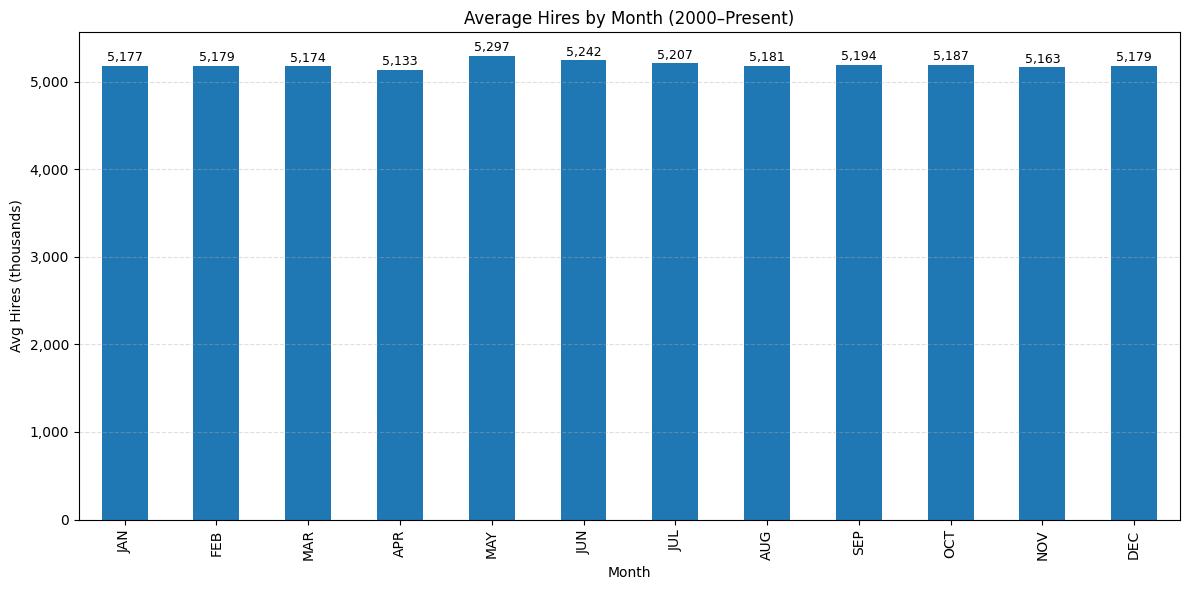

In [23]:
from matplotlib.ticker import FuncFormatter
# compute calendar-ordered monthly averages
order = [m.upper() for m in calendar.month_abbr if m]  # ['JAN','FEB',...,'DEC']
season = (df.groupby('month_name', sort=False)['hires_thousands']
            .mean()
            .reindex(order))

# rounded series for labels (no long decimals)
season_rounded = season.round(0)  # e.g., 5,177

# plot
fig, ax = plt.subplots(figsize=(12,6))
season.plot(kind='bar', ax=ax)

ax.set_title('Average Hires by Month (2000–Present)')
ax.set_xlabel('Month')
ax.set_ylabel('Avg Hires (thousands)')

# y-axis with thousands separators (e.g., 5,200)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{int(x):,}"))

# light horizontal gridlines
ax.grid(axis='y', linestyle='--', alpha=0.4)

# value labels on bars
for i, v in enumerate(season_rounded.values):
    ax.text(i, season.values[i] + 20,  # a tiny offset above the bar
            f"{int(v):,}",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [29]:
# print the table rounded
season_df = season_rounded.rename('avg_hires_thousands').to_frame()
season_df

,avg_hires_thousands
month_name,
JAN,5177.0
FEB,5179.0
MAR,5174.0
APR,5133.0
MAY,5297.0
JUN,5242.0
JUL,5207.0
AUG,5181.0
SEP,5194.0


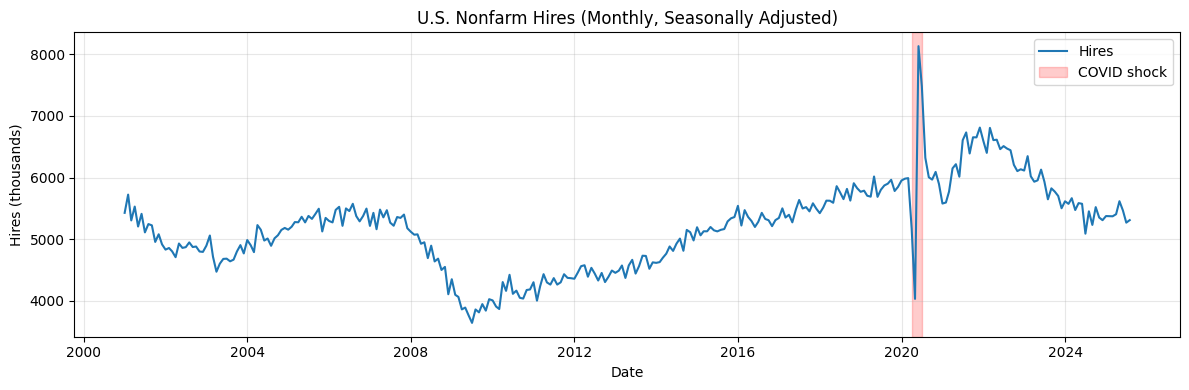

In [30]:
plt.figure(figsize=(12,4))
plt.plot(df['month'], df['hires_thousands'], label="Hires")
plt.title('U.S. Nonfarm Hires (Monthly, Seasonally Adjusted)')
plt.xlabel('Date')
plt.ylabel('Hires (thousands)')
plt.grid(alpha=0.3)

# highlight COVID shock (Apr–Jun 2020)
plt.axvspan(pd.to_datetime("2020-04-01"), pd.to_datetime("2020-06-30"),
            color='red', alpha=0.2, label="COVID shock")

plt.legend()
plt.tight_layout()
plt.show()


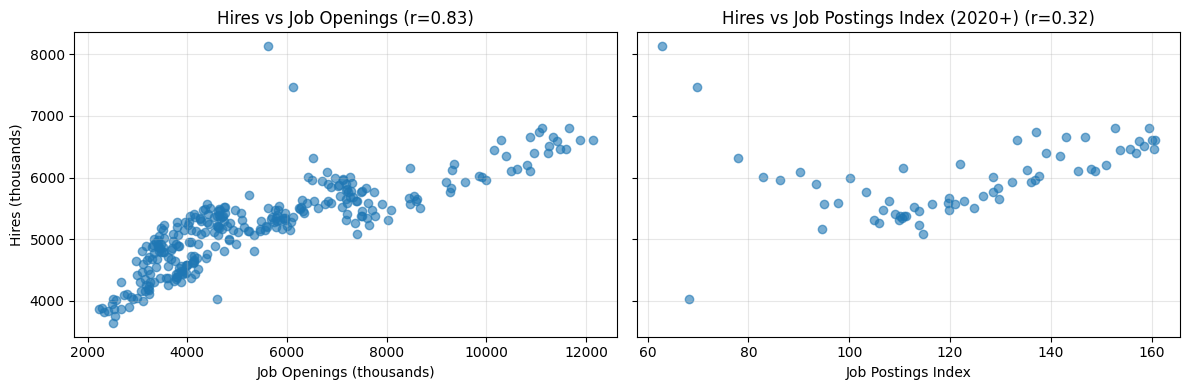

In [32]:
recent = df.dropna(subset=['postings_index_m'])

# correlations (Pearson)
r_open = df[['openings_thousands','hires_thousands']].dropna().corr().iloc[0,1]
r_post = recent[['postings_index_m','hires_thousands']].corr().iloc[0,1]

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

# Left: Hires vs Job Openings (full history)
axes[0].scatter(df['openings_thousands'], df['hires_thousands'], alpha=0.6)
axes[0].set_title(f'Hires vs Job Openings (r={r_open:.2f})')
axes[0].set_xlabel('Job Openings (thousands)')
axes[0].set_ylabel('Hires (thousands)')
axes[0].grid(alpha=0.3)

# Right: Hires vs Job Postings (2020+ only)
axes[1].scatter(recent['postings_index_m'], recent['hires_thousands'], alpha=0.6)
axes[1].set_title(f'Hires vs Job Postings Index (2020+) (r={r_post:.2f})')
axes[1].set_xlabel('Job Postings Index')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [41]:
# keep rows where lag12 exists
base = df.dropna(subset=['hires_thousands','hires_lag12']).copy()
base = base.sort_values('month').reset_index(drop=True)
base['y_true'] = base['hires_thousands']
base['y_pred'] = base['hires_lag12']   # seasonal naive

# error columns
base['err']  = base['y_true'] - base['y_pred']
base['ae']   = base['err'].abs()
base['se']   = base['err']**2
base['ape']  = (base['ae'] / base['y_true']) * 100.0

# MASE denominator: in-sample MAE of seasonal differences (12-month)
# https://robjhyndman.com/papers/mase.pdf
seasonal_diff = df['hires_thousands'].diff(12).dropna().abs()
mase_denom = seasonal_diff.mean()

def summarize(scores_df):
    mae  = scores_df['ae'].mean()
    rmse = np.sqrt(scores_df['se'].mean())
    mape = scores_df['ape'].mean()
    # guard if mase_denom is nan or 0
    mase = mae / mase_denom if mase_denom and not np.isnan(mase_denom) else np.nan
    # directional accuracy: did we get the sign of change right vs last month?
    s = scores_df.copy()
    s['delta_true'] = s['y_true'].diff()
    s['delta_pred'] = s['y_pred'].diff()
    da = np.mean(np.sign(s['delta_true'].dropna()) == np.sign(s['delta_pred'].dropna()))
    return {
        'MAE': round(mae,1),
        'RMSE': round(rmse,1),
        'MAPE%': round(mape,2),
        'MASE': round(mase,2) if not np.isnan(mase) else None,
        'Directional_Accuracy': round(da,2)
    }

# 1) Last 5 years
cutoff = base['month'].max() - pd.DateOffset(years=5)
recent = base[base['month'] >= cutoff]
baseline_recent = summarize(recent)

# 2) Full evaluation window
baseline_full = summarize(base)

print("Baseline (Seasonal-Naive) — last 5 years:", baseline_recent)
print("Baseline (Seasonal-Naive) — full window :", baseline_full)


Baseline (Seasonal-Naive) — last 5 years: {'MAE': np.float64(499.1), 'RMSE': np.float64(642.3), 'MAPE%': np.float64(8.32), 'MASE': np.float64(1.43), 'Directional_Accuracy': np.float64(0.47)}
Baseline (Seasonal-Naive) — full window : {'MAE': np.float64(348.8), 'RMSE': np.float64(488.1), 'MAPE%': np.float64(6.8), 'MASE': np.float64(1.0), 'Directional_Accuracy': np.float64(0.46)}


In [42]:
def pretty(d):
    out = {}
    for k, v in d.items():
        # cast numpy scalars to Python float
        x = float(v)
        # format
        if k in ["MAE","RMSE"]:
            out[k] = f"{x:,.0f}"          # no decimals, thousands sep
        elif k == "MAPE%":
            out[k] = f"{x:.2f}%"
        elif k == "MASE":
            out[k] = f"{x:.2f}"
        elif k == "Directional_Accuracy":
            out[k] = f"{x:.2f}"
        else:
            out[k] = x
    return out

tbl = pd.DataFrame(
    [pretty(baseline_recent), pretty(baseline_full)],
    index=["Last 5 years", "Full window"]
)

tbl


,MAE,RMSE,MAPE%,MASE,Directional_Accuracy
Last 5 years,499,642,8.32%,1.43,0.47
Full window,349,488,6.80%,1.00,0.46


In [43]:
slide_cols = [
    'month','month_name','hires_thousands','openings_thousands',
    'unrate_pct','claims_monthly','postings_index_m',
    'indpro_index','recession_dummy','hires_lag12','hires_ma3'
]
df[slide_cols].head(8)


,month,month_name,hires_thousands,openings_thousands,unrate_pct,claims_monthly,postings_index_m,indpro_index,recession_dummy,hires_lag12,hires_ma3
0,2000-12-31,DEC,5426,5088,3.9,346000.0,NaN,92.3457,0,NaN,NaN
1,2001-01-31,JAN,5722,5234,4.2,340000.0,NaN,91.8908,0,NaN,NaN
2,2001-02-28,FEB,5303,5097,4.2,371250.0,NaN,91.2851,0,NaN,5483.666667
3,2001-03-31,MAR,5528,4762,4.3,387200.0,NaN,91.0585,1,NaN,5517.666667
4,2001-04-30,APR,5204,4615,4.4,396750.0,NaN,90.7384,1,NaN,5345.000000
5,2001-05-31,MAY,5410,4425,4.3,394500.0,NaN,90.2607,1,NaN,5380.666667
6,2001-06-30,JUN,5109,4361,4.5,397200.0,NaN,89.7811,1,NaN,5241.000000
7,2001-07-31,JUL,5244,4447,4.6,398000.0,NaN,89.2352,1,NaN,5254.333333
